In [19]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import Normalize
import imageio
import cv2
import heapq
import math

In [20]:
class cell:
    def __init__(self, x, z):
        self.x = x
        self.z = z
        self.f = float('inf')
        self.g = float('inf')
        self.h = 0
        self.parent = None
        self.blocked = False
        
    def __lt__(self, other):
        return self.f < other.f

def heuristic(start, end):
    maximum = max(abs(start.x - end.x), abs(start.z - end.z))
    minimum = min(abs(start.x - end.x), abs(start.z - end.z))
    x = (maximum - minimum) + (minimum * math.sqrt(2))
    return x
    
def getNeighborCells(grid, node, offsets, speed, factor, gaussianMap):
    neighbors = []
    for dx, dz, cost in offsets:
        nx, nz = node.x + dx, node.z + dz
        if 0 <= nx < grid.shape[0] and 0 <= nz < grid.shape[1]: 
            neighbor = grid[nx, nz]
            if not neighbor.blocked:
                influenceCost = factor * (gaussianMap[node.z, node.x] + gaussianMap[nz, nx]) / 2
                print(f"distance cost {cost} and influence cost {influenceCost}")
                neighbors.append((neighbor, influenceCost+cost))
    return neighbors


In [21]:
def aStar(binaryMap, grid, start, goal, offsets, speed, factor, gaussianMap, obstacles):
    openList = []
    closedList = set()
    startCell = grid[start[0], start[1]]
    goalCell = grid[goal[0], goal[1]]
    startCell.g = 0
    startCell.h = heuristic(startCell, goalCell)
    #startCell.h = 0
    startCell.f = startCell.g + startCell.h
    heapq.heappush(openList, (startCell.f, startCell))
    while openList:
        _, current = heapq.heappop(openList)
        if current in closedList:
            continue
        if current.x == goalCell.x and current.z == goalCell.z:
            timeInterval = 100
            path = []
            while current:
                path.append((current.x, current.z, timeInterval))
                current = current.parent
                timeInterval -= 0.3
            path = path[::-1]
            print(path)
            return path
        closedList.add(current)
        neighbors = getNeighborCells(grid, current, offsets, speed, factor, gaussianMap)
        for neighbor, cost in neighbors:
            if neighbor in closedList:
                continue
            temp_g = current.g + cost
            if temp_g < neighbor.g:
                neighbor.g = temp_g
                #neighbor.h = heuristic(neighbor, goalCell)
                neighbor.h = 0
                neighbor.f = neighbor.g + neighbor.h
                neighbor.parent = current
                heapq.heappush(openList, (neighbor.f, neighbor))
    
    return None


In [22]:
def createGoalMap(binaryMap, goal, offsets, obstacles):
    goalGradient = np.full(binaryMap.shape, np.inf, dtype=float)
    pq = []

    x, z = goal
    goalGradient[z, x] = 0
    heapq.heappush(pq, (0, (x, z)))

    while pq:
        cost, (x, z) = heapq.heappop(pq)
        for dx, dz, moveCost in offsets:
            nx, nz = x + dx, z + dz
            if 0 <= nx < binaryMap.shape[0] and 0 <= nz < binaryMap.shape[1]:
                newCost = cost + moveCost
                if newCost < goalGradient[nz, nx]:
                    goalGradient[nz, nx] = newCost
                    heapq.heappush(pq, (newCost, (nx, nz)))
    # Normalize
    maxVal = np.max(goalGradient[np.isfinite(goalGradient)])
    minVal = np.min(goalGradient[np.isfinite(goalGradient)])
    goalGradient = (goalGradient - minVal) / (maxVal - minVal)
    for ox, oz in obstacles:
        if 0 <= ox < binaryMap.shape[1] and 0 <= oz < binaryMap.shape[0]:
            goalGradient[oz, ox] = 1
    return goalGradient

In [23]:
def createGradientMap(binaryMap, sitterMap, start, goal, obstacles, sitters, offsets):
    gradientMap = np.full(binaryMap.shape, np.inf, dtype=float)
    pq = []
    for x, z in sitters:
        sitterCost = 0
        gradientMap[z, x] = sitterCost
        heapq.heappush(pq, (sitterCost, (x, z)))
    for x, z in obstacles:
        if (x, z) not in sitters:
            obstacleCost = 2
            gradientMap[z, x] = obstacleCost
            heapq.heappush(pq, (obstacleCost, (x, z)))
    while pq:
        cost, (x, z) = heapq.heappop(pq)
        influence = 1
        if (x, z) in sitters:
            influence = 0.5
        for dx, dz, moveCost in offsets:
            nx, nz = x + dx, z + dz
            if 0 <= nx < binaryMap.shape[0] and 0 <= nz < binaryMap.shape[1]:
                newCost = cost + moveCost * influence
                if newCost < gradientMap[nz, nx]:
                    gradientMap[nz, nx] = newCost
                    heapq.heappush(pq, (newCost, (nx, nz)))
    maxVal = np.max(gradientMap[np.isfinite(gradientMap)])
    minVal = np.min(gradientMap[np.isfinite(gradientMap)])
    gradientMap = (gradientMap - minVal) / (maxVal - minVal)
    #gradientMap = gradientMap / maxVal
    print("MAXVAL: "+str(maxVal))
    print("MINVAL: "+str(minVal))
    maxVal = np.max(gradientMap[np.isfinite(gradientMap)])
    minVal = np.min(gradientMap[np.isfinite(gradientMap)])
    print("MAXVAL: "+str(maxVal))
    print("MINVAL: "+str(minVal))
    return gradientMap


In [24]:
def plotGradientMap(gradientMap, start, goal, width, length):
    norm = Normalize(vmin=0, vmax=1)
    plt.figure(figsize=(8, 8))
    plt.imshow(gradientMap, cmap='viridis', origin='lower', interpolation='nearest', vmin=0, vmax=1, extent=(0, width, 0, length)) #plot gradient map as heatmap
    plt.plot(start[0], start[1], 'bo', label = "start")  #plot start point -> blue
    plt.plot(goal[0], goal[1], 'go', label = "goal")    #plot end point -> green
    plt.title("Environment Gradient Map")
    plt.xlabel("X Axis")
    plt.ylabel("Z Axis")
    plt.colorbar(label='Cost Value')
    plt.legend()
    plt.show()


In [25]:
def createGaussianMap(gradientMap, width, length):
    gaussianMap = np.zeros((width, length))
    X, Z = np.meshgrid(np.arange(width), np.arange(length))
    #temp = float(sum([gradientMap[z, x] for x in range(width) for z in range(length)])) / (width*length)
    variances = [0.1, 0.25, 0.75]
    var = variances[1]
    mean = 1
    #print(mean)
    for x in range(width):
        for z in range(length):
            distance = gradientMap[z, x]
            influence = 1 / (math.sqrt(var * 2 * math.pi))
            gaussian = influence * np.exp(-(((distance - mean) ** 2) / (2 * var)))
            gaussianMap[z, x] = gaussian
    maxVal = np.max(gaussianMap[gaussianMap != np.inf])
    gaussianMap = gaussianMap / maxVal
    #print("MAXVAL: "+str(maxVal))
    maxVal = np.max(gaussianMap[np.isfinite(gaussianMap)])
    minVal = np.min(gaussianMap[np.isfinite(gaussianMap)])
    print("MAXVAL: "+str(maxVal))
    print("MINVAL: "+str(minVal))
    return gaussianMap


In [26]:
def plotGaussianMap(gaussianMap, start, goal, width, length):
    #norm = Normalize(vmin=0, vmax=1)
    plt.figure(figsize=(8, 8))
    colors = {
        'red':   ((0.0, 1.0, 1.0),
                (0.17, 1.0, 1.0),
                (0.33, 1.0, 1.0),
                (0.5, 0.0, 0.0),
                (0.67, 0.0, 0.0),
                (0.83, 0.5, 0.5),
                (1.0, 0.5, 0.5)),
        'green': ((0.0, 0.0, 0.0),
                (0.17, 0.5, 0.5),
                (0.33, 1.0, 1.0),
                (0.5, 1.0, 1.0),
                (0.67, 1.0, 1.0),
                (0.83, 0.0, 0.0),
                (1.0, 0.0, 0.0)),
        'blue':  ((0.0, 0.0, 0.0),
                (0.17, 0.0, 0.0),
                (0.33, 0.0, 0.0),
                (0.5, 0.0, 0.0),
                (0.67, 1.0, 1.0),
                (0.83, 1.0, 1.0),
                (1.0, 0.5, 0.5))
    }
    cmap = LinearSegmentedColormap('my_colormap',colors,256)   
    plt.imshow(gaussianMap, cmap=cmap, origin='lower', interpolation='nearest', extent=(0, width, 0, length)) #plot gradient map as heatmap
    plt.plot(start[0], start[1], 'bo', label = "start")  #plot start point -> blue
    plt.plot(goal[0], goal[1], 'go', label = "goal")    #plot end point -> green
    plt.title("Environment Gaussian Map")
    plt.xlabel("X Axis")
    plt.ylabel("Z Axis")
    plt.legend()
    plt.show()


In [27]:
def plotXZ(path, gridSize, obstacles, sitters):
    plt.figure(figsize=(8, 8))
    plt.plot(start[0], start[1], 'bo', label = "start")  #plot start point -> blue
    plt.plot(goal[0], goal[1], 'go', label = "goal")    #plot end point -> green
    if obstacles:
        obsX, obsZ = zip(*obstacles)
        plt.scatter(obsX, obsZ, color='grey', label='Obstacles', s=10)
    if sitters:
        sitX, sitZ = zip(*sitters)
        plt.scatter(sitX, sitZ, color='black', label='Sitters', s=10)
    
    if path:
        pathX, path_z = zip(*path)
        plt.plot(pathX, path_z, color='blue', linewidth=2, label='Path')
    
    plt.title('Gradient Map with Path')
    plt.xlabel("X Axis")
    plt.ylabel("Z Axis")
    plt.legend()
    plt.show()


In [28]:
def plotXZOverTime(path, interval, gridSize, staticObstacles, movingObstacles):
    numFrames = 10
    filename = 'xz_time_progression2.gif'
    fig, ax = plt.subplots(figsize=(6, 6))
    xs, zs, ys = zip(*path)
    print(ys)
    minTime, maxTime = min(ys), max(ys)
    print(minTime)
    print(maxTime)
    intervals = np.linspace(minTime, maxTime, numFrames)
    images = []
    for t in intervals:
        ax.clear()
        ax.set_xlim(0, gridSize[0])
        ax.set_ylim(0, gridSize[1])
        ax.set_xlabel('X Axis')
        ax.set_ylabel('Z Axid')
        ax.set_title(f'XZ View at Time {round(t - minTime, 2)}')
        
        plt.plot(start[0], start[1], 'bo', label = "start")  #plot start point -> blue
        plt.plot(goal[0], goal[1], 'go', label = "goal")    #plot end point -> green
                
        for obs in staticObstacles:
            ax.scatter(*obs, c='black', marker='s', label='Static' if obs == list(staticObstacles)[0] else "")
        
        points = [(x, z) for x, z, y in zip(xs, zs, ys) if y <= t]
        if points:
            xVals, zVals = zip(*points)
            ax.scatter(xVals, zVals, c='blue', marker='o')
        
        plt.draw()
        plt.pause(0.001)
        fig.canvas.draw()
        width, height = fig.canvas.get_width_height()
        image = np.array(fig.canvas.buffer_rgba()) 
        expectedSize = (height, width, 4)
        if image.shape != expectedSize:
            image = cv2.resize(image, (width, height))
        image = image[:, :, :3]
        images.append(image)
        imageio.mimsave(filename, images, fps=2)
    plt.show()
    

In [29]:
offsets = [(-1, 0, 1), (1, 0, 1), (0, -1, 1), (0, 1, 1), (-1, -1, math.sqrt(2)), (1, 1, math.sqrt(2)), (1, -1, math.sqrt(2)), (-1, 1, math.sqrt(2))]
width, length = 100, 100
grid = np.array([[cell(x, z) for z in range(width)] for x in range(length)])
binaryMap = np.zeros((width, length))
gradientMap = np.zeros((width, length))
time_step = 0.05
speed = 3
benches = []
walls = []
leftSitters = []
rightSitters = []
sitterMap = np.zeros((width, length))

In [30]:
#benches in center
for x in range(40, 60):
    for z in range(35, 65):
        benches.append((x, z))
        binaryMap[z, x] = 1
        grid[x, z].blocked = True

#left sitters
for x in range(40, 60):
    for z in range(35, 65):
        if 43 > x > 40:
            #leftSitters.append((x, z))
            #sitterMap[z, x] = 1.5
            #grid[x, z].blocked = True
            pass

#right sitters
for x in range(40, 60):
    for z in range(35, 65):
        if 60 > x > 57:
            rightSitters.append((x, z))
            sitterMap[z, x] = 1.5
            grid[x, z].blocked = True

#bottom wall
for x in range(0, 100):
    for z in range(0, 2):
        walls.append((x, z))
        binaryMap[z, x] = 1
        grid[x, z].blocked = True

#top wall
for x in range(0, 100):
    for z in range(98, 100):
        if not(x > 15 and x < 35) and not(x > 65 and x < 85):
            walls.append((x, z))
            binaryMap[z, x] = 1
            grid[x, z].blocked = True

#left wall
for x in range(0, 2):
    for z in range(0, 100):
        if not(z > 15 and z < 35) and not(z > 65 and z < 85):
            walls.append((x, z))
            binaryMap[z, x] = 1
            grid[x, z].blocked = True

#right wall
for x in range(98, 100):
    for z in range(0, 100):
        if not(z > 15 and z < 35) and not(z > 65 and z < 85):
            walls.append((x, z))
            binaryMap[z, x] = 1
            grid[x, z].blocked = True
            

In [31]:
sitters = leftSitters+rightSitters
#start = (50, 5)
start = (20, 5)
#start = (99, 80)
goal = (75, 99) #right side goal door
#goal = (99, 20)

MAXVAL: 25.72792206135786
MINVAL: 0.0
MAXVAL: 1.0
MINVAL: 0.0


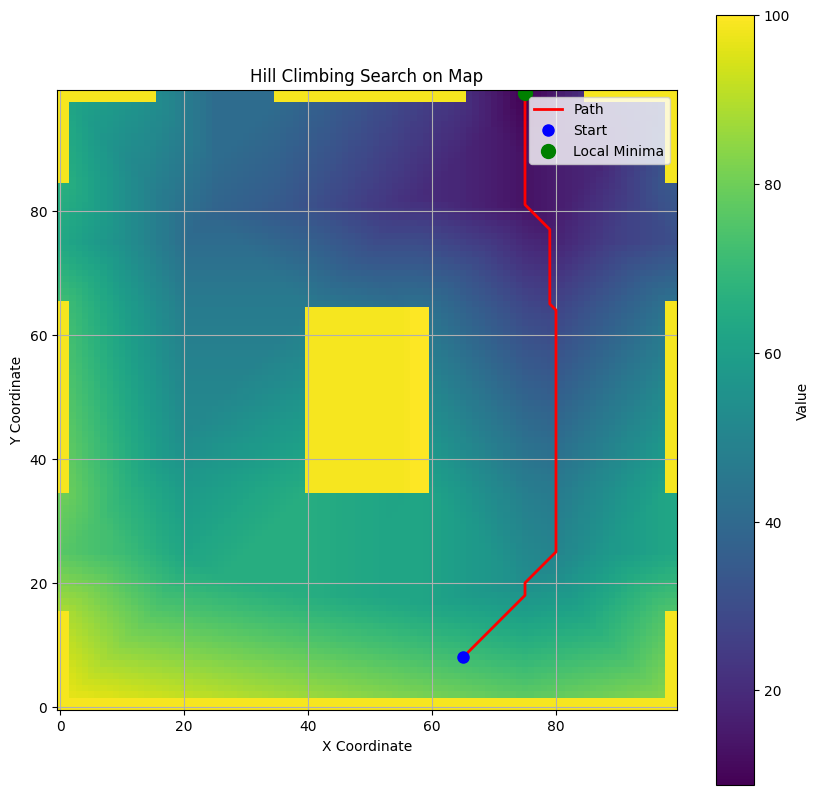

In [32]:
def hill_climb(map_data, start):
    x, y = start
    path = [(x, y)]
    visited = set(path)
    directions = [(-1, 0), (1, 0), (0, -1), (0, 1),
                  (-1, -1), (-1, 1), (1, -1), (1, 1)]

    while True:
        current_val = map_data[y, x]
        found_better = False
        best_neighbor = (x, y)
        max_val = current_val

        for dx, dy in directions:
            nx, ny = x + dx, y + dy
            if 0 <= nx < map_data.shape[1] and 0 <= ny < map_data.shape[0]:
                if map_data[ny, nx] < max_val and (nx, ny) not in visited:
                    max_val = map_data[ny, nx]
                    best_neighbor = (nx, ny)
                    found_better = True

        if not found_better:
            break

        x, y = best_neighbor
        visited.add((x, y))
        path.append((x, y))

    return path

def visualize_hill_climb_path(grid, path, start):
    plt.figure(figsize=(10, 10))
    plt.imshow(grid, cmap='viridis', origin='lower')
    plt.colorbar(label='Value')

    if path:
        x_coords = [p[0] for p in path]
        y_coords = [p[1] for p in path]
        plt.plot(x_coords, y_coords, '-', color='red', linewidth=2, label='Path')
        plt.plot(start[0], start[1], 'bo', markersize=8, label='Start')
        plt.plot(x_coords[-1], y_coords[-1], 'go', markersize=10, label='Local Minima')

    plt.title("Hill Climbing Search on Map")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.legend()
    plt.grid(True)
    plt.show()

start = (65, 8)
obstacles = benches+walls+sitters
goalMap = createGoalMap(binaryMap, goal, offsets, obstacles)
gradientMap = createGradientMap(binaryMap, sitterMap, start, goal, benches+walls, sitters, offsets)    #total gradient
gradientMap = 1 - gradientMap
alphaVal = 0.835
grid = goalMap*alphaVal + gradientMap*(1-alphaVal)
#plotGradientMap(grid, start, goal, width, length)  #plotting gradient map
grid = grid*100

path = hill_climb(grid, start)
visualize_hill_climb_path(grid, path, start)

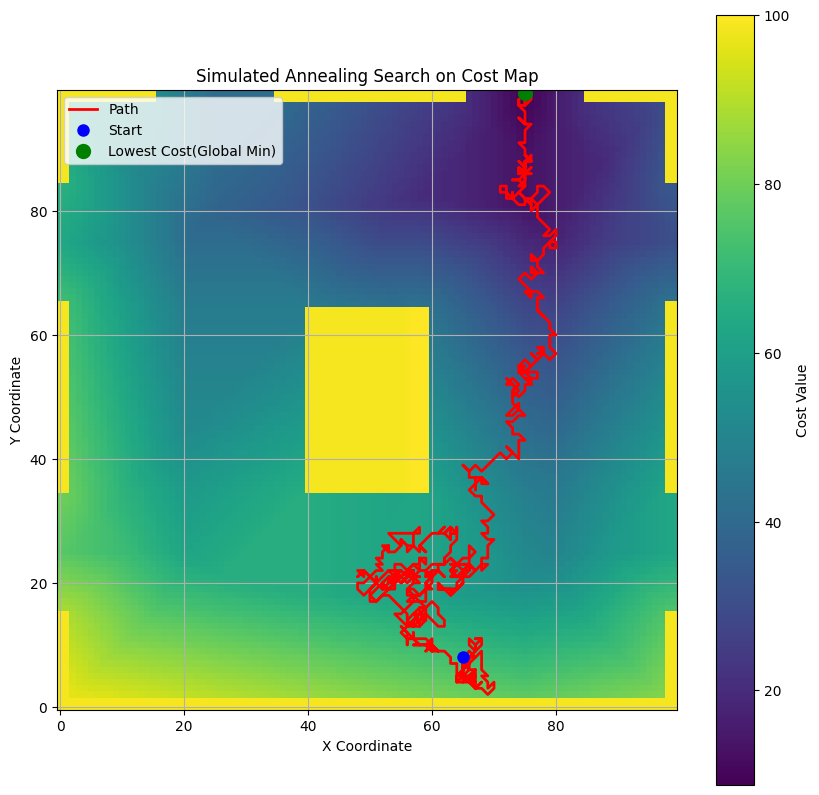

In [33]:
import random
import math

def simulated_annealing(grid, start, max_steps=20000, initial_temp=20.0, cooling_rate=0.995):
    x, y = start
    current_cost = grid[y, x]
    best_point = (x, y)
    best_cost = current_cost
    path = [(x, y)]

    temp = initial_temp
    rows, cols = grid.shape

    directions = [(-1, 0), (1, 0), (0, -1), (0, 1),
                  (-1, -1), (-1, 1), (1, -1), (1, 1)]

    for step in range(max_steps):
        dx, dy = random.choice(directions)
        nx, ny = x + dx, y + dy

        if 0 <= nx < cols and 0 <= ny < rows:
            new_cost = grid[ny, nx]
            delta = new_cost - current_cost

            if delta < 0 or random.random() < math.exp(-delta / temp):
                x, y = nx, ny
                current_cost = new_cost
                path.append((x, y))

                if current_cost < best_cost:
                    best_cost = current_cost
                    best_point = (x, y)

        temp *= cooling_rate
        if temp < 1e-4:
            break

    return path, best_point

def visualize_sa_path(grid, path, best_point, start):
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 10))
    plt.imshow(grid, cmap='viridis', origin='lower')
    plt.colorbar(label='Cost Value')

    if path:
        x_coords = [p[0] for p in path]
        y_coords = [p[1] for p in path]
        plt.plot(x_coords, y_coords, '-', color='red', linewidth=2, label='Path')
        plt.plot(start[0], start[1], 'bo', markersize=8, label='Start')
        plt.plot(best_point[0], best_point[1], 'go', markersize=10, label='Lowest Cost(Global Min)')

    plt.title("Simulated Annealing Search on Cost Map")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.legend()
    plt.grid(True)
    plt.show()
start = (65,8)
path, best = simulated_annealing(grid, start)
#path = hill_climb(grid, start)
visualize_sa_path(grid, path, goal, start)